# Analyse des activations

Ce notebook sert à analyser un dataset d'activation de neuronnes

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

## Configuration

In [2]:
# Fichier csv contenant les activations d'un model
sm_file = "../../data/activations/activations.csv"


# fichier csv contenant les activations de plusieurs model
mm_file = "../../data/activations/multi_mlp.csv"

# Cette variable indique les nombres de neuronnes et le nombre de couche caché 
# elle doit correspondre à celle utilisé pour créer le jeux de données
hidden_sizes = [128, 64] 


In [3]:
activations = pd.read_csv(sm_file)
mean_per_nb = activations.drop(columns=['nb_pred']).groupby("nb_true").mean()

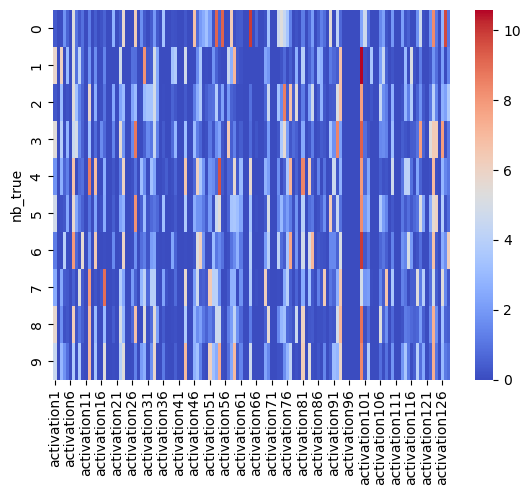

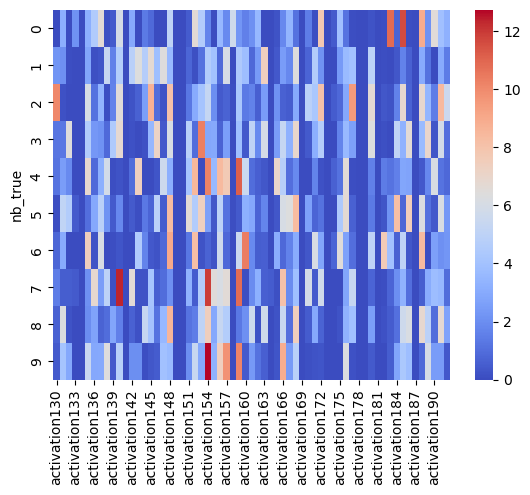

In [4]:

cursor = 0
for i in range(len(hidden_sizes)):
    sns.heatmap(
        mean_per_nb.iloc[:,cursor:cursor+hidden_sizes[i]],
        cmap="coolwarm", fmt=".2f"
        )
    plt.show()
    cursor += hidden_sizes[i]+1

## Analyse en composante principale

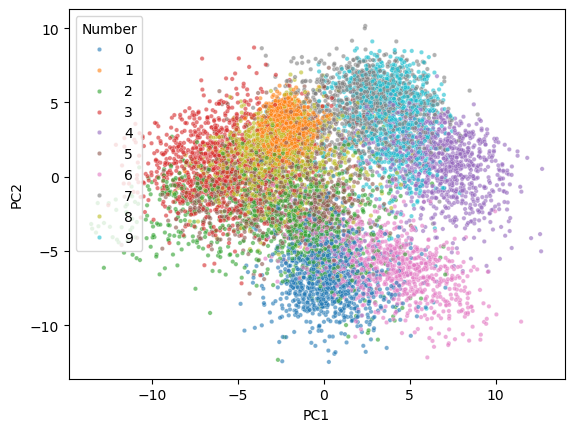

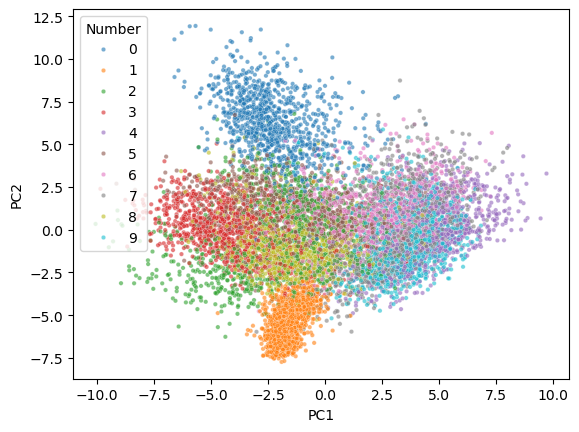

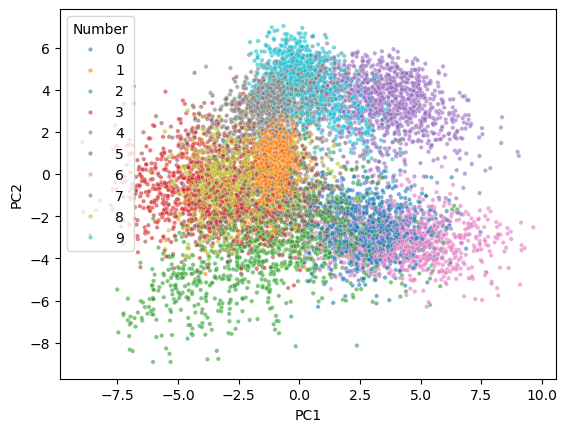

In [5]:
def plot_acp(data, labels):
    # on commence par normaliser les données 
    data_normalized = StandardScaler().fit_transform(data)

    # ensuite on effectue l'ACP avec 2 composantes
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(data_normalized)

    # transforme les résultats en dataframe 
    pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])
    pca_df['Number'] = labels

    sns.scatterplot(
        x='PC1', y='PC2',
        hue='Number',
        palette='tab10',  # Palette de 10 couleurs
        data=pca_df,
        s=10, alpha=0.6  # Réduire la taille des points pour plus de clarté
    )
    plt.show()


activations_reduced = activations.drop(columns=['nb_true', 'nb_pred'])
plot_acp(activations_reduced, activations["nb_true"])
plot_acp(activations_reduced.iloc[:,:128], activations["nb_true"])
plot_acp(activations_reduced.iloc[:,129:], activations["nb_true"])

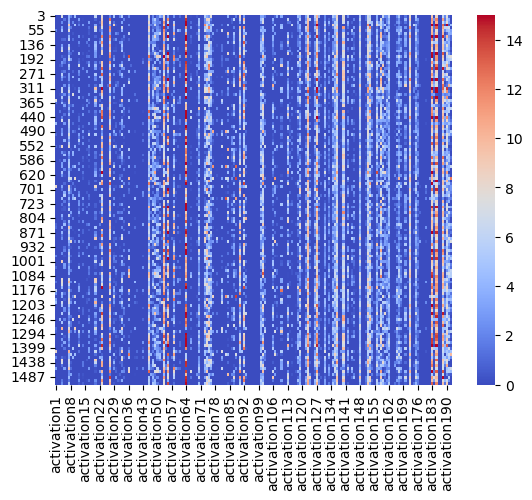

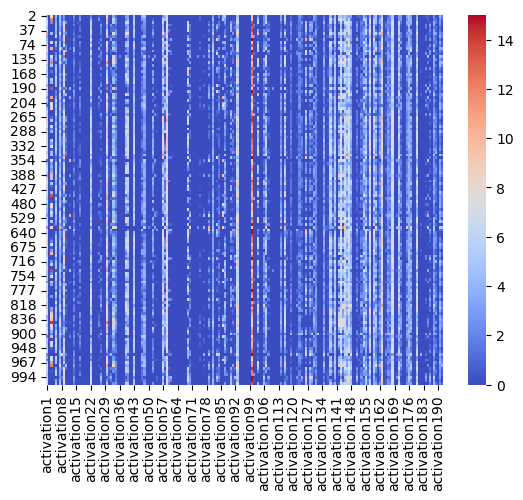

In [6]:
def activation_heatmap(data, limit = 128):
    sns.heatmap(data.drop(columns=['nb_true', 'nb_pred']).head(limit), cmap="coolwarm", fmt=".2f", vmax=15)
    plt.show()

activation_heatmap(activations[activations['nb_true'] == 0])
activation_heatmap(activations[activations['nb_true'] == 1])

In [7]:
X = activations.iloc[:, 2:]
y = activations["nb_pred"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

params = {
    "objective": "multi:softmax",  # Problème de classification multiclasses
    "num_class": 10,               # Nombre de classes
    "max_depth": 4,               # Profondeur maximale des arbres
    "eta": 0.3,                   # Taux d'apprentissage (learning rate)
    "eval_metric": "mlogloss"     # Log-loss pour évaluer le modèle
}

num_round = 50
bst = xgb.train(params, dtrain, num_round)

preds = bst.predict(dtest)

accuracy = accuracy_score(y_test, preds)
print(f"Précision du modèle : {accuracy:.2f}")

Précision du modèle : 0.98
